In [2]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import spacy
import textacy
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import stellargraph as sg
import tensorflow as tf
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from stellargraph import datasets
from IPython.display import display, HTML
from sklearn.cluster import KMeans
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC

In [3]:
df0 = pd.read_csv("Data/cancer_dataset.csv", encoding='latin1', index_col=0)
df = df0["a"]
df0.head()

,0,a
0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


In [4]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df0['0'])
set(labels)

{0, 1, 2}

In [5]:
#

In [6]:
with open("Data/topics_clf.pickle", "rb") as f:
    topics = pkl.load(f)
topics = np.array(topics)

In [7]:
topics

array([168, 221,  97, ...,  59, 107,   2])

In [8]:
d = {}
for t in set(topics):
    d[t] = []
for i, t in enumerate(topics):
    d[t].append(i)

In [9]:
labels_in_clusters = []
most_common_label_in_clusters = {}
for k in d:
    #if k != -1:
    labels_in_clusters.append([labels[i] for i in d[k]])
    most_common_label_in_clusters[k] = np.argmax(np.bincount(labels_in_clusters[-1]))

In [10]:
topics_mapped = [most_common_label_in_clusters[topic] for topic in topics]

In [11]:
#

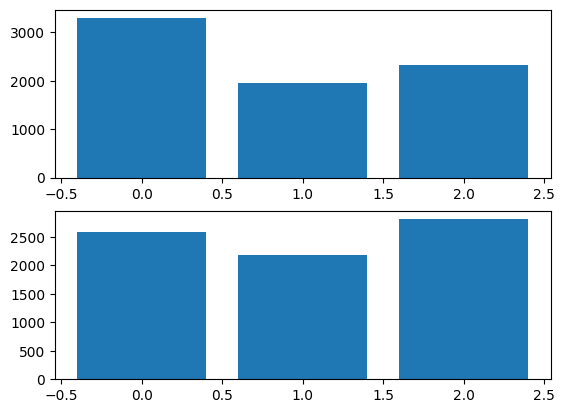

In [12]:
fig, ax = plt.subplots(2, 1)
ax[0].bar([0, 1, 2], np.bincount((topics_mapped)))
ax[1].bar([0, 1, 2], np.bincount(labels))
plt.show()

In [13]:
#

In [14]:
with open("Data/graphs.pkl", "rb") as f:
    Gs = pkl.load(f)

GG = nx.disjoint_union_all(Gs)

In [15]:
with open("Data/combined_graphed.pkl", "rb") as f:
    node_vectors_list_cmb = pkl.load(f)
word_vec_dict = {}
for i, node in enumerate(list(GG.nodes)):
    word_vec_dict[node] = node_vectors_list_cmb[0][i]

with open("Data/individual_graphed.pkl", "rb") as f:
    node_vectors_list_ind = pkl.load(f)

In [16]:
len_each_graph = [len(i) for i in node_vectors_list_ind]

vec_list = np.array(node_vectors_list_cmb[0])

In [17]:
labels_extended = []
for i, l in enumerate(len_each_graph):
    labels_extended.extend([labels[i]]*l)

In [18]:
# Classification on whole data
model = GaussianNB()
model.fit(vec_list, labels_extended)

y_pred = model.predict(vec_list)

y_pred_reduced = []
cumsum_len_each_graph = np.cumsum(len_each_graph)
for i in range(len(cumsum_len_each_graph)):
    if i==0:
        y_pred_reduced.append(np.argmax(np.bincount(y_pred[:cumsum_len_each_graph[i]])))
    else:
        y_pred_reduced.append(np.argmax(np.bincount(y_pred[cumsum_len_each_graph[i-1]:cumsum_len_each_graph[i]])))

accuray = accuracy_score(y_pred_reduced, labels)
f1 = f1_score(y_pred_reduced, labels, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.4095112285336856
F1 Score: 0.48479871972121086


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    vec_list, labels_extended, test_size=0.3
)

# Classification
model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuray = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.4813346940527972
F1 Score: 0.5290823942593854


In [33]:
y_pred = model.predict(vec_list)

In [20]:
#

In [21]:
def linear_assignment(cost_matrix):
    try:
        import lap
        _, x, y = lap.lapjv(cost_matrix, extend_cost=True)
        return np.array([[y[i], i] for i in x if i >= 0])
    except ImportError:
        from scipy.optimize import linear_sum_assignment
        x, y = linear_sum_assignment(cost_matrix)
        return np.array(list(zip(x, y)))

def map_labels(true_labels, pred_labels, cluster_no):
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    cost_matrix = np.zeros((cluster_no, cluster_no))
    for i in range(cluster_no):
        for j in range(cluster_no):
            cost_matrix[i][j] = np.sum((true_labels == i) & (pred_labels == j))
    
    mapping = linear_assignment(-cost_matrix)[:, 1]
    d = {}
    for i, j in enumerate(mapping):
        d[i] = j
    return d

In [22]:
topics_extended = []
for i, l in enumerate(len_each_graph):
    topics_extended.extend([topics_mapped[i]]*l)

In [39]:
len(vec_list)

1009270

In [45]:
#differences_index = []
#for i, l in enumerate(labels_extended):
#    if l != topics_extended[i]:
#        differences_index.append(i)
#len(differences_index)

In [46]:
differences_index = []
for i, l in enumerate(y_pred):
    if l != topics_extended[i]:
        differences_index.append(i)
len(differences_index)

519149

In [47]:
vec_list_reduced = np.delete(vec_list, differences_index, axis=0)
bert_reduced = np.delete(topics_extended, differences_index)
labels_extended_reduced = np.delete(labels_extended, differences_index)

In [48]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    vec_list_reduced, labels_extended_reduced, test_size=0.3
)

In [49]:
model_r = GaussianNB()
model_r.fit(X_train_r, y_train_r)

GaussianNB()

In [50]:
y_pred_r = model_r.predict(X_test_r)
accuray = accuracy_score(y_pred_r, y_test_r)
f1 = f1_score(y_pred_r, y_test_r, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.6981916116351666
F1 Score: 0.7176068782665759


In [28]:
# Approach 2